# back4app Database of U.S. vehicle makes and models (2000-2022)
The following analyzes our query of the [back4app.com](https://www.back4app.com/database/back4app/car-make-model-dataset) database, an open-source dataset providing detailed information about motor vehicles manufactured in the US between the years 1992 and 2022.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
import seaborn as sns

matplotlib.rcParams.update({'font.size': 14})
pd.set_option('display.max_columns', 500)

In [2]:
universe = pd.read_csv('../data/make_model_database_mod.csv')

In [3]:
universe.shape

(8274, 5)

In [4]:
universe.head()

Make Detailed Model Model Category  Year
0  Acura             CL    CL    Coupe  2001
1  Acura             CL    CL    Coupe  2002
2  Acura             CL    CL    Coupe  2003
3  Acura            ILX   ILX    Sedan  2013
4  Acura            ILX   ILX    Sedan  2014

# Vehicle Makes/Manufacturers
The [back4app.com](https://www.back4app.com/database/back4app/car-make-model-dataset) database contains 59 distinct passenger vehicle makes. We drop 4 small vehicle manufacturers (e.g. Fisker, Polestar, Panoz, Rivian), 8 exotic car manufacturers (e.g. Ferrari, Lamborghini, Maserati, Rolls-Royce, McLaren, Bentley, Aston Martin, Lotus), and 7 brands with sparse information in the dataset (e.g. Alfa Romeo, Daewoo, Isuzu, Genesis, Mayback, Plymouth, Oldsmobile), reducing the number of distinct vehicle manufacturers in the data to 40.

In [5]:
universe.Make.unique()

array(['Acura', 'Audi', 'BMW', 'Buick', 'Cadillac', 'Chevrolet',
       'Chrysler', 'Dodge', 'Fiat', 'Ford', 'GMC', 'HUMMER', 'Honda',
       'Hyundai', 'INFINITI', 'Jaguar', 'Jeep', 'Kia', 'Land Rover',
       'Lexus', 'Lincoln', 'MINI', 'Mazda', 'Mercedes-Benz', 'Mercury',
       'Mitsubishi', 'Nissan', 'Pontiac', 'Porsche', 'RAM', 'Saab',
       'Saturn', 'Scion', 'Subaru', 'Suzuki', 'Tesla', 'Toyota',
       'Volkswagen', 'Volvo', 'smart'], dtype=object)

# Unique vehicle combinations in database

The [back4app.com](https://www.back4app.com/database/back4app/car-make-model-dataset) database is uniquely identified by the make-(detailed-)model-category-year. For example, 2006 BMW Z4 M Convertible or 2017 Audi A5 Sport Coupe.

In [6]:
len(universe[['Make', 'Detailed Model', 'Category', 'Year']].drop_duplicates())

8274

In [7]:
assert(universe[['Make', 'Detailed Model', 'Category', 'Year']].duplicated().all() == False)

### Detailed make-model-year combinations (aggregating category)

E.g. 2001 Ford F-150 regular cab, 2003 Ford F-250 super cab

In [8]:
len(universe[['Make', 'Detailed Model', 'Year']].drop_duplicates())

7252

### Detailed make-model combinations (aggregating category, pooling years)

E.g. Ford F-150 regular cab, Ford F-250 super cab

In [9]:
len(universe[['Make', 'Detailed Model']].drop_duplicates())

930

### Aggregated make-model combinations (aggregating category & detailed models, pooling years)

E.g. [Ford F-150 regular cab, Ford F-250 super cab] -> Ford F-Series

In [10]:
len(universe[['Make', 'Model']].drop_duplicates())

574

# Number of Models per Manufacturer over the Period

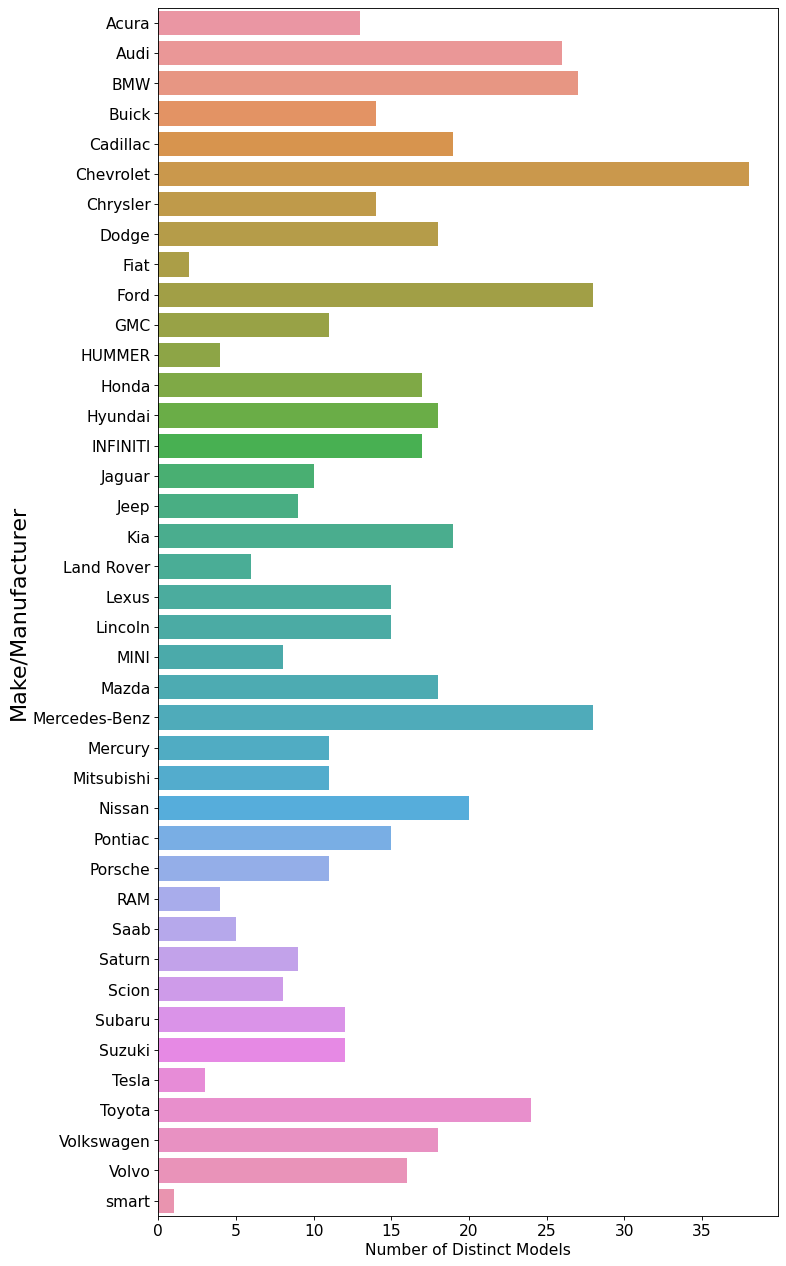

In [11]:
models = universe.groupby("Make")['Model'].nunique().reset_index().rename(columns={'Model': 'Count'})
figure(figsize=(10, 20), dpi=80)
sns.barplot(data=models, x='Count', y='Make')
plt.xlabel("Number of Distinct Models")
plt.ylabel("Make/Manufacturer", fontsize=20)
plt.show()

# Number of Models by Manufacturer and Year

In [12]:
foo = universe[['Make', 'Model', 'Year']].drop_duplicates().groupby(['Make', 'Year'])['Model'].count().reset_index()
foo['total_yrs'] = foo.groupby('Make')['Year'].transform('count')

### Manufacturers with 2022 Models in Data
2022 model information is missing for most manufacturers. For those with this information present, only a few models are contained in our data. For that reason we'll drop 2022 from this part of the analysis.

In [13]:
foo.loc[foo.Year==2022]['Make'].drop_duplicates().tolist()

['Acura',
 'Chevrolet',
 'GMC',
 'Honda',
 'Hyundai',
 'Jeep',
 'Kia',
 'Mercedes-Benz',
 'Mitsubishi',
 'Nissan',
 'Subaru',
 'Volkswagen']

In [14]:
foo = foo.loc[foo.Year < 2022].reset_index(drop=True)

In [15]:
# This will help us present data in descending order of number of models
foo['avg_model_count'] = foo.groupby(['Make'])['Model'].transform('mean')

### Manufacturers Present in all Years (2000-2021/22)

In [16]:
present_all_yrs = foo.loc[foo.total_yrs>=22]['Make'].drop_duplicates().tolist()
print(present_all_yrs)

['Acura', 'Audi', 'BMW', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge', 'Ford', 'GMC', 'Honda', 'Hyundai', 'INFINITI', 'Jaguar', 'Jeep', 'Kia', 'Land Rover', 'Lexus', 'Lincoln', 'Mazda', 'Mercedes-Benz', 'Mitsubishi', 'Nissan', 'Porsche', 'Subaru', 'Toyota', 'Volkswagen', 'Volvo']


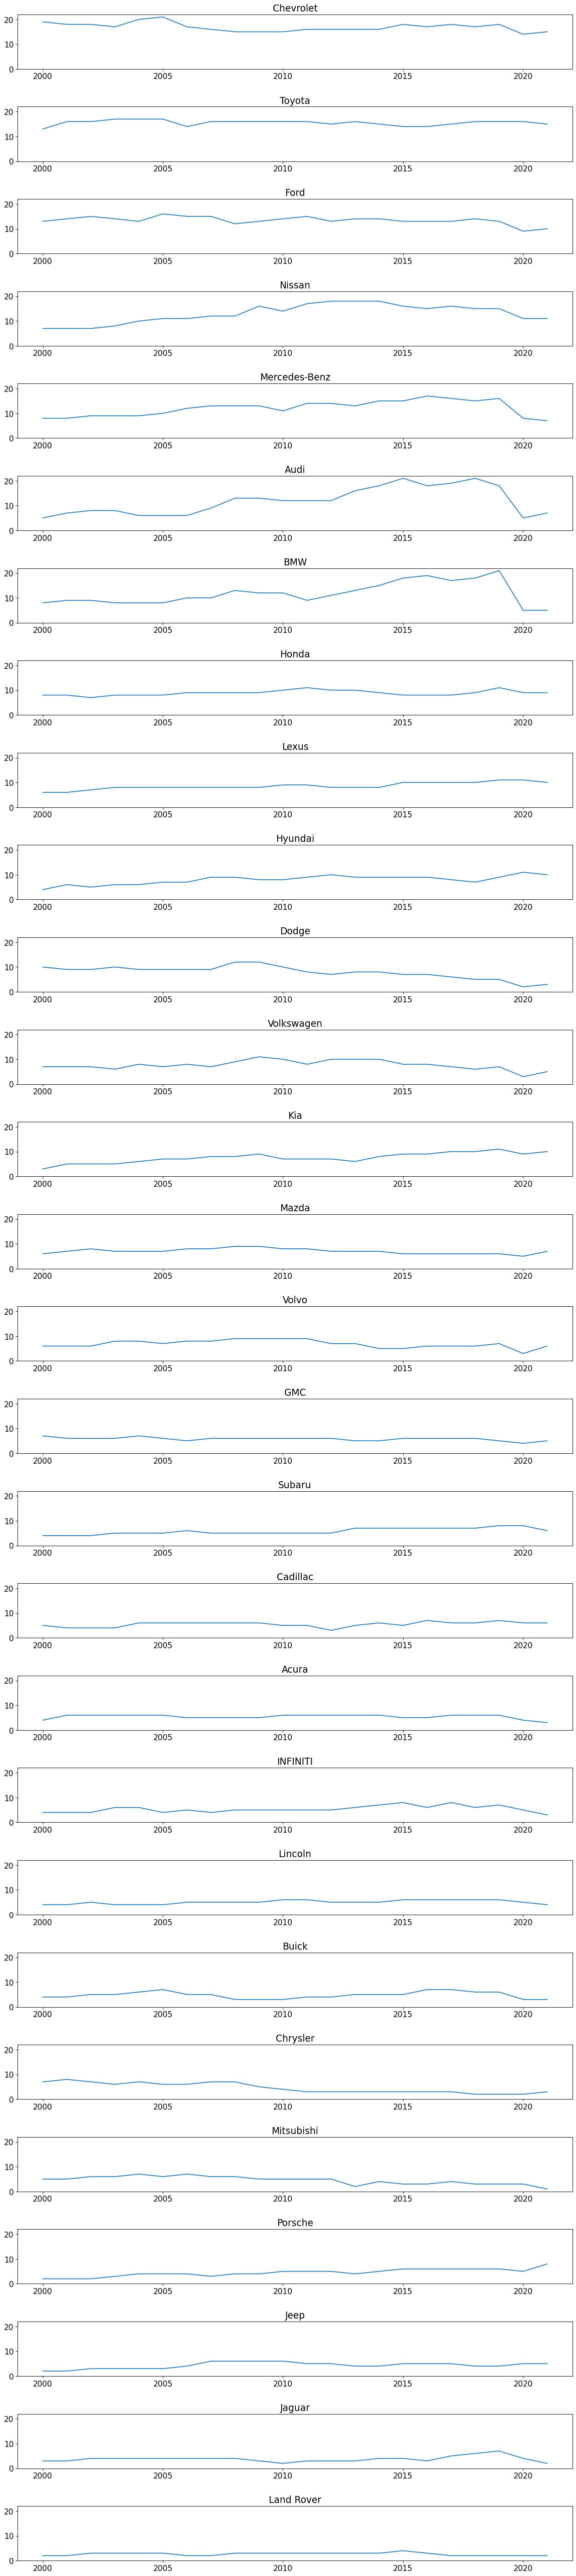

In [17]:
all_yrs = foo.loc[foo.Make.isin(present_all_yrs)]
all_yrs = all_yrs.sort_values(by=['avg_model_count', 'Year'], ascending=[False, True]).reset_index(drop=True)

fig, ax = plt.subplots(len(present_all_yrs), 1, figsize=(15, 65), dpi=80, sharex=False)
lst = all_yrs.Make.unique()
for i, make in enumerate(lst):
    temp = all_yrs[all_yrs.Make==make][['Year', 'Model']].set_index('Year')
    ax[i].plot(temp, label=make)
    ax[i].set_title(make)
    ax[i].set_ylim(0, 22)
fig.tight_layout(pad=2.0)

### Manufacturers Not Present in all Years

In [18]:
not_always_present = foo.loc[foo.total_yrs<22]['Make'].drop_duplicates().tolist()
print(not_always_present)

['Fiat', 'HUMMER', 'MINI', 'Mercury', 'Pontiac', 'RAM', 'Saab', 'Saturn', 'Scion', 'Suzuki', 'Tesla', 'smart']


In [19]:
import matplotlib.ticker as mticker

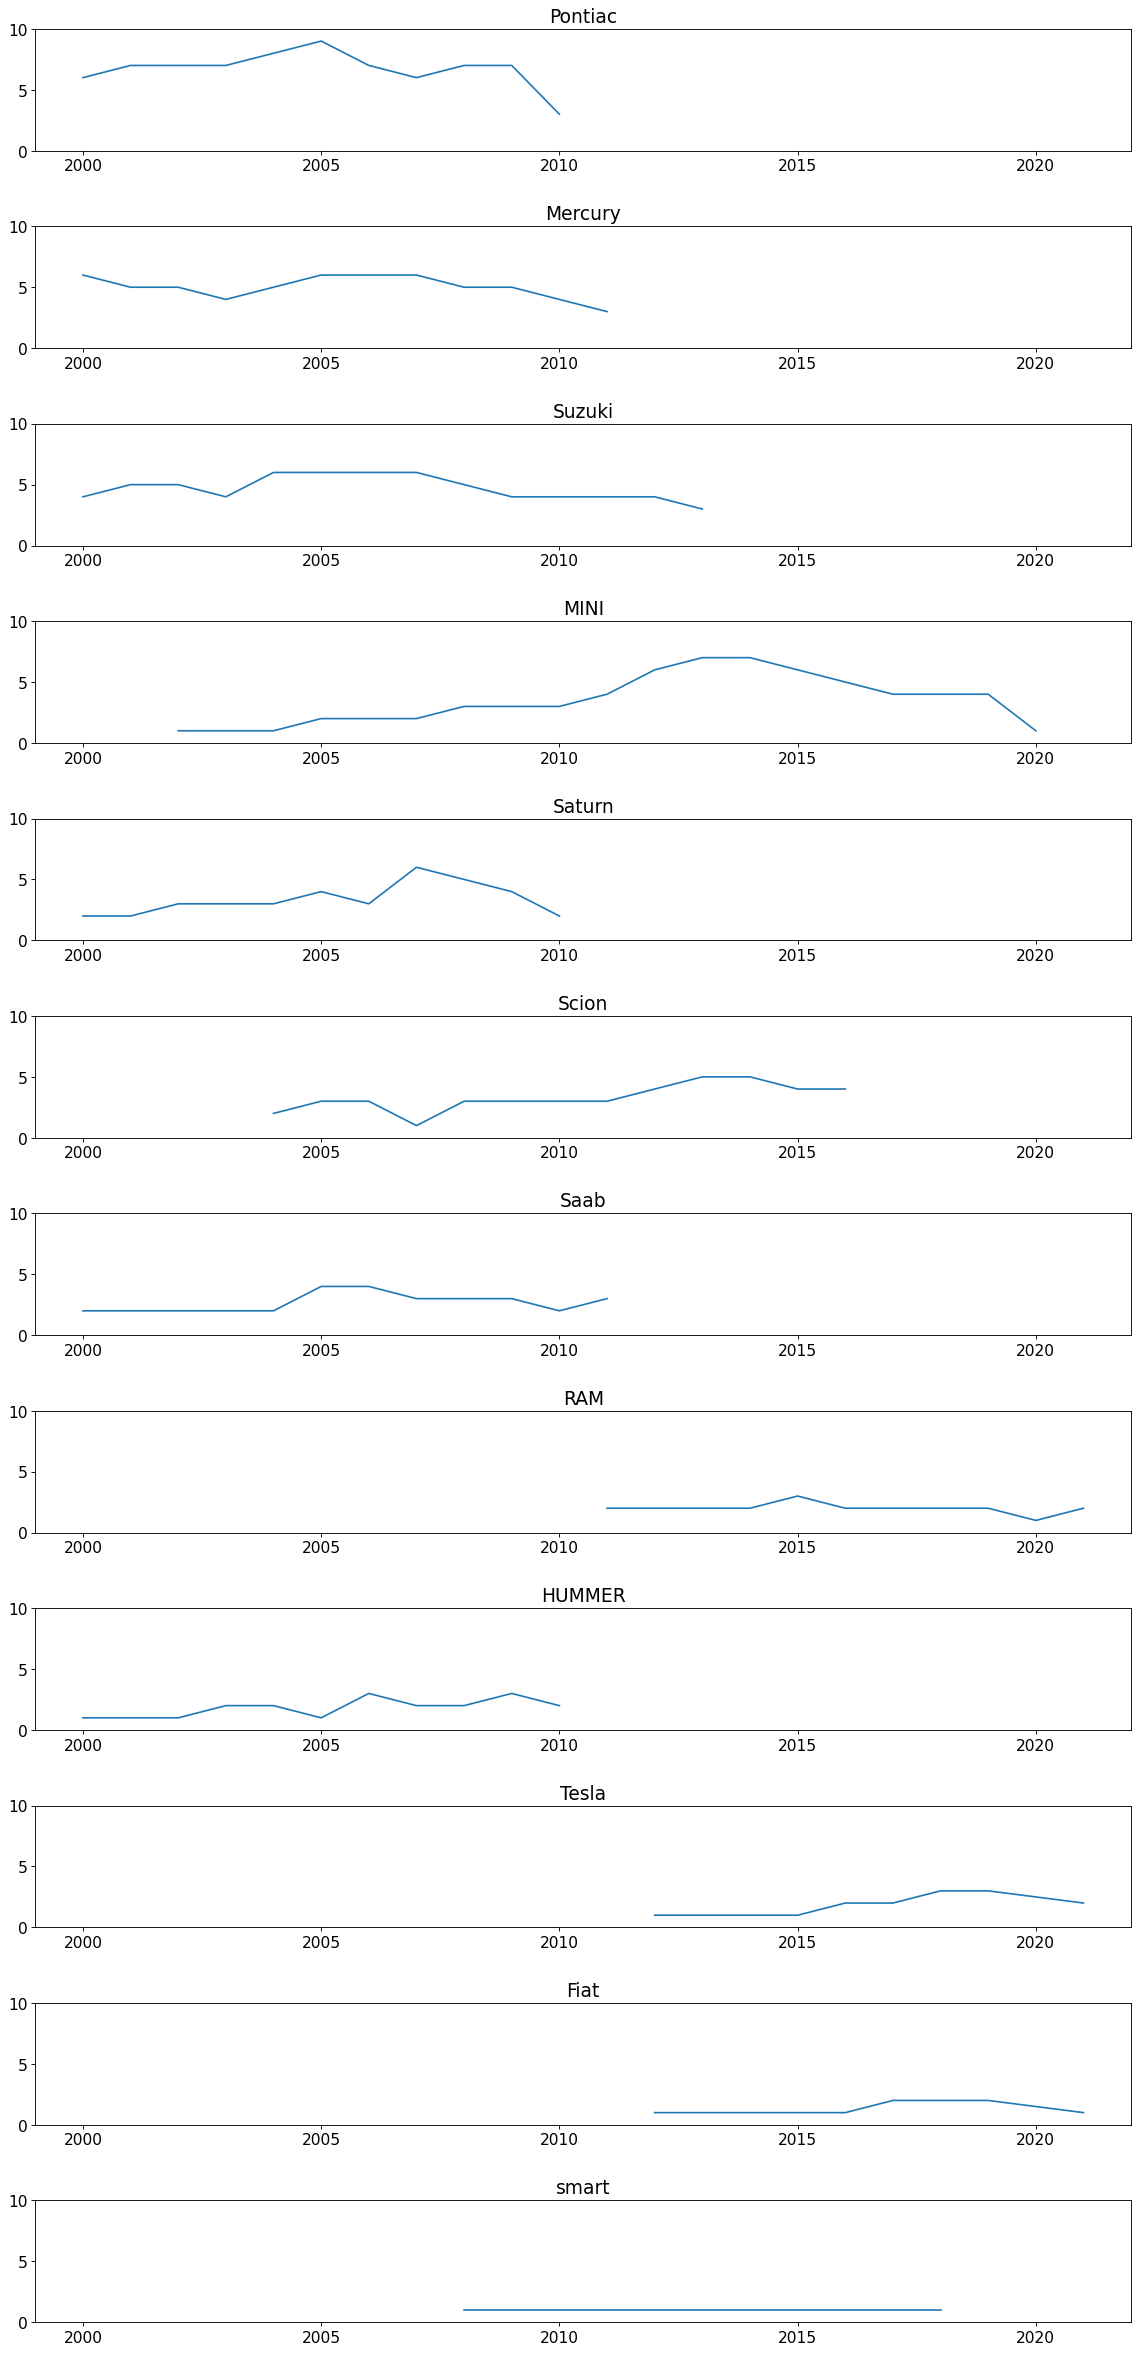

In [20]:
not_all_yrs = foo.loc[foo.Make.isin(not_always_present)]
not_all_yrs = not_all_yrs.sort_values(by=['avg_model_count', 'Year'], ascending=[False, True]).reset_index(drop=True)


fig, ax = plt.subplots(len(not_always_present), 1, figsize=(15, 30), dpi=80, sharex=False)
lst = not_all_yrs.Make.unique()
for i, make in enumerate(lst):
    temp = not_all_yrs[not_all_yrs.Make==make][['Year', 'Model']].set_index('Year')
    ax[i].plot(temp, label=make)
    ax[i].set_title(make)
    ax[i].set_ylim(0, 10)
    ax[i].set_xlim(1999, 2022)
    ax[i].set_xticks([int(i) for i in range(2000, 2023, 5)])
fig.tight_layout(pad=2.0)